In [26]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import datasets, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras import backend
import glob

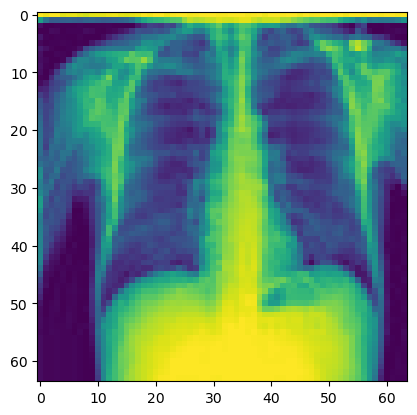

In [27]:
im = plt.imread('/kaggle/input/medical-mnist/CXR/000000.jpeg')
plt.imshow(im);

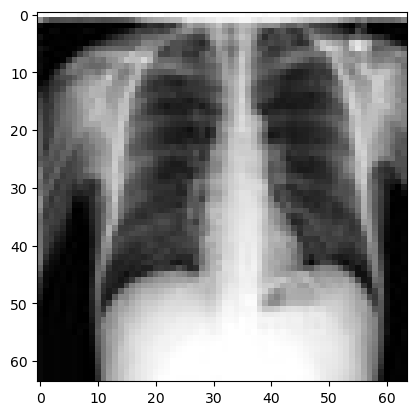

In [28]:
plt.imshow(im, 'gray');

In [29]:
im.shape

(64, 64)

## Importando os arquivos:

In [30]:
files = glob.glob('/kaggle/input/medical-mnist/**/*.jpeg', recursive = True)

In [31]:
len(files)

58954

In [32]:
df = pd.DataFrame({'path': files})
df.head()

,path
0,/kaggle/input/medical-mnist/AbdomenCT/003646.jpeg
1,/kaggle/input/medical-mnist/AbdomenCT/003998.jpeg
2,/kaggle/input/medical-mnist/AbdomenCT/001273.jpeg
3,/kaggle/input/medical-mnist/AbdomenCT/001609.jpeg
4,/kaggle/input/medical-mnist/AbdomenCT/007646.jpeg


In [33]:
df['path'][0]

'/kaggle/input/medical-mnist/AbdomenCT/003646.jpeg'

In [34]:
df['class'] = df['path'].apply(lambda x: x.split('/')[4])
df.head()

,path,class
0,/kaggle/input/medical-mnist/AbdomenCT/003646.jpeg,AbdomenCT
1,/kaggle/input/medical-mnist/AbdomenCT/003998.jpeg,AbdomenCT
2,/kaggle/input/medical-mnist/AbdomenCT/001273.jpeg,AbdomenCT
3,/kaggle/input/medical-mnist/AbdomenCT/001609.jpeg,AbdomenCT
4,/kaggle/input/medical-mnist/AbdomenCT/007646.jpeg,AbdomenCT


In [35]:
df['class'].value_counts()

AbdomenCT    10000
Hand         10000
CXR          10000
HeadCT       10000
ChestCT      10000
BreastMRI     8954
Name: class, dtype: int64

## Separando Treino e Teste:

In [36]:
from sklearn.model_selection import train_test_split

In [37]:
X_train, X_test, y_train, y_test = train_test_split(df['path'] , df['class'], test_size = 0.1)
len(X_train)

53058

In [38]:
len(X_test)

5896

In [39]:
BATCH_SIZE = 128

In [40]:
data_generator = ImageDataGenerator(rescale = 1./255, validation_split = 0.15)

In [41]:
df_train = pd.concat([X_train, y_train], axis = 1)
df_train.head()

,path,class
56214,/kaggle/input/medical-mnist/ChestCT/004537.jpeg,ChestCT
58873,/kaggle/input/medical-mnist/ChestCT/003818.jpeg,ChestCT
39195,/kaggle/input/medical-mnist/HeadCT/006451.jpeg,HeadCT
31200,/kaggle/input/medical-mnist/CXR/003743.jpeg,CXR
3375,/kaggle/input/medical-mnist/AbdomenCT/005634.jpeg,AbdomenCT


In [42]:
train_generator = data_generator.flow_from_dataframe(dataframe = df_train, x_col = 'path', y_col = 'class', 
                                                     class_mode = 'categorical', batch_size = BATCH_SIZE, 
                                                     target_size = (64,64), subset = 'training', 
                                                     color_mode = 'grayscale')

Found 45100 validated image filenames belonging to 6 classes.


In [43]:
valid_generator = data_generator.flow_from_dataframe(dataframe = df_train, x_col = 'path', y_col = 'class', 
                                                     class_mode = 'categorical', batch_size = BATCH_SIZE, 
                                                     target_size = (64,64), subset = 'validation', 
                                                     color_mode = 'grayscale')

Found 7958 validated image filenames belonging to 6 classes.


## Compilação:

In [44]:
def build_model():

    model = Sequential()

    model.add(layers.Conv2D(filters = 32, kernel_size = 2, activation = "relu", input_shape = (64, 64, 1)))
    model.add(layers.MaxPooling2D(pool_size = 2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())

    model.add(layers.Dense(28, activation = 'relu'))
    model.add(layers.Dense(6, activation = 'softmax'))

    return model

In [45]:
model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 63, 63, 32)        160       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 31, 31, 32)        0         
                                                                 
 flatten_1 (Flatten)         (None, 30752)             0         
                                                                 
 dense_2 (Dense)             (None, 28)                861084    
                                                                 
 dense_3 (Dense)             (None, 6)                 174       
                                                      

In [46]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [47]:
checkpoint = ModelCheckpoint('medical_image_model.hdf5', monitor = 'val_loss', verbose = 1, mode = 'min', 
                             save_best_only = True)

In [48]:
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 5, mode = 'min', verbose = 1)

In [49]:
model.fit(train_generator, callbacks = [checkpoint, early_stop], steps_per_epoch = train_generator.samples//BATCH_SIZE, 
          validation_data = valid_generator, validation_steps = valid_generator.samples//BATCH_SIZE, epochs = 25)

Epoch 1/25
352/352 [==============================] - ETA: 0s - loss: 0.0917 - accuracy: 0.9750
Epoch 1: val_loss improved from inf to 0.01285, saving model to medical_image_model.hdf5
352/352 [==============================] - 110s 310ms/step - loss: 0.0917 - accuracy: 0.9750 - val_loss: 0.0128 - val_accuracy: 0.9979
Epoch 2/25
352/352 [==============================] - ETA: 0s - loss: 0.0097 - accuracy: 0.9981
Epoch 2: val_loss improved from 0.01285 to 0.00639, saving model to medical_image_model.hdf5
352/352 [==============================] - 89s 253ms/step - loss: 0.0097 - accuracy: 0.9981 - val_loss: 0.0064 - val_accuracy: 0.9990
Epoch 3/25
352/352 [==============================] - ETA: 0s - loss: 0.0039 - accuracy: 0.9991
Epoch 3: val_loss improved from 0.00639 to 0.00470, saving model to medical_image_model.hdf5
352/352 [==============================] - 104s 295ms/step - loss: 0.0039 - accuracy: 0.9991 - val_loss: 0.0047 - val_accuracy: 0.9987
Epoch 4/25
352/352 [=============

In [50]:
model

In [51]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [52]:
test_imgs = [img_to_array(load_img(im_path, color_mode = "grayscale")) for im_path in X_test]

In [53]:
y_pred = model.predict(np.array(test_imgs))

185/185 [==============================] - 2s 12ms/step


In [54]:
y_pred.argmax(axis = 1)

array([2, 4, 3, ..., 3, 3, 3])

In [55]:
from sklearn.metrics import confusion_matrix

In [56]:
y_test.values

array(['CXR', 'HeadCT', 'ChestCT', ..., 'ChestCT', 'AbdomenCT',
       'AbdomenCT'], dtype=object)

In [57]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [58]:
y_test = le.fit_transform(y_test)

In [59]:
le.classes_

array(['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT'],
      dtype=object)

In [60]:
cm = confusion_matrix(y_test, y_pred.argmax(axis = 1))
cm

array([[   0,    0,    0,  966,    0,    0],
       [ 505,    0,   28,  165,  191,    0],
       [   0,    0,  964,   14,   10,    0],
       [   0,    0,    0, 1017,    0,    0],
       [   0,    0,    8,    3,  987,    0],
       [   0,    0,    1,  282,  755,    0]])

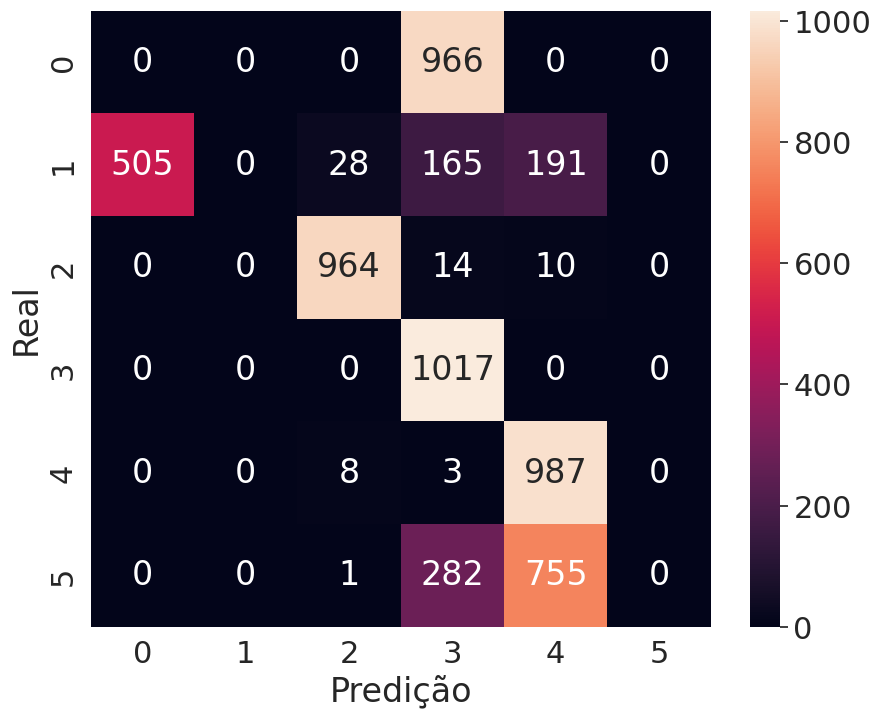

In [61]:
import seaborn as sns

plt.figure(figsize = (10, 8))
sns.set(font_scale = 2)
sns.heatmap(cm, annot = True, fmt = "d").set(xlabel = "Predição", ylabel = "Real");